<h1 style="font-size:24px; color: MediumSeaGreen; font-weight: bold; text-align: center; margin:auto">KOLAY RESTAURANT DATA & PROFITABILITY / POPULARITY ANALYSIS</h1>

In [1]:
# Necessary function for interactive dataframes.
def init_datatable_mode():
    """Initialize DataTable mode for pandas DataFrame represenation."""
    
    from IPython.core.display import display, Javascript

    # configure path to the datatables library using requireJS
    # that way the library will become globally available
    display(Javascript("""
        require.config({
            paths: {
                DT: 'https://cdn.datatables.net/1.10.19/js/jquery.dataTables.min',
            }
        });
        $('head').append('<link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.10.19/css/jquery.dataTables.min.css">');
    """))

    def _repr_datatable_(self):
        """Return DataTable representation of pandas DataFrame."""
        # classes for dataframe table (optional)
        classes = ['table', 'table-striped', 'table-bordered']

        # create table DOM
        script = (
            f'$(element).html(`{self.to_html(index=False, classes=classes)}`);\n'
        )

        # execute jQuery to turn table into DataTable
        script += """
            require(["DT"], function(DT) {
                $(document).ready( () => {
                    // Turn existing table into datatable
                    $(element).find("table.dataframe").DataTable();
                })
            });
        """

        return script

    pd.DataFrame._repr_javascript_ = _repr_datatable_

<span style="font-size:20px; color: red; font-weight: bold">Importing libraries.</span>

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot
import plotly as py
import cufflinks as cf
from IPython.core.display import HTML, Javascript
init_datatable_mode()

<IPython.core.display.Javascript object>

<span style="font-size:20px; color: red; font-weight: bold">Importing JSON converted data.</span>

In [3]:
oo  = pd.read_pickle('ordersdf')

In [4]:
# # Profitability / popularity dataframe
pp = pd.DataFrame()

<span style="font-size:20px; color: red; font-weight: bold">Top 10 sold products.</span>

In [5]:
oo['Product'].value_counts().nlargest(10)

Tulum Peyniri     16637
Lahmacun          14462
Ayran             12247
Acılı Lahmacun     6277
Adana Kebap        5415
Küçük Su           4414
İçli Köfte         4097
Kola               3790
Kuver              3741
Ezogelin           2829
Name: Product, dtype: int64

<span style="font-size:20px; color: red; font-weight: bold">Plotting best selling products...</span>

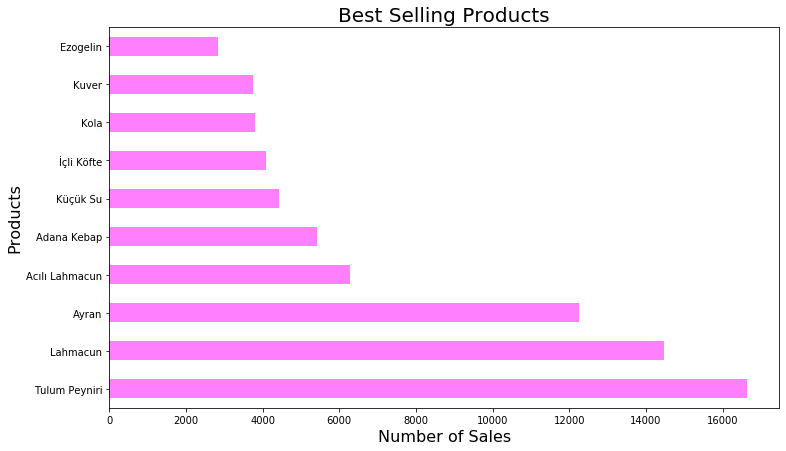

In [6]:
# Best selling products visualization
oo['Product'].value_counts().nlargest(10).plot(kind='barh',figsize=(12,7), color='magenta', alpha=0.5)
plt.title('Best Selling Products', fontsize=20)
plt.xlabel('Number of Sales',fontsize=16)
plt.ylabel('Products',fontsize=16);

<span style="font-size:20px; color: red; font-weight: bold">Plotting worst selling products...</span>

In [7]:
new_list = oo['Product'].value_counts(ascending = True)

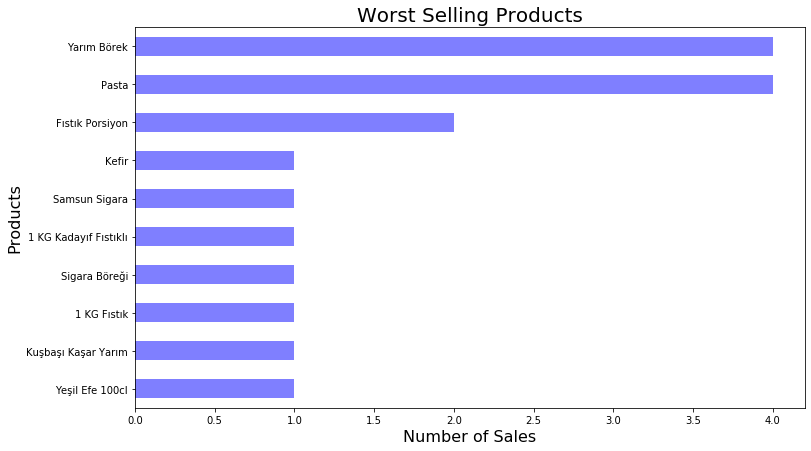

In [33]:
new_list.nsmallest(10).plot(kind='barh',figsize=(12,7), color='blue', alpha=0.5)
plt.title('Worst Selling Products', fontsize=20)
plt.xlabel('Number of Sales',fontsize=16)
plt.ylabel('Products',fontsize=16);

<span style="font-size:20px; color: red; font-weight: bold">Adding columns to profitability/popularity dataframe.</span>

In [9]:
columnssOrder = ['Sold', 'Price','Cost','Profit']
pp = pp.reindex(columns = columnssOrder)

In [10]:
pp.insert(0, 'Products', True)
pp.insert(5, 'Product', True)

In [11]:
pp['Product'] = oo['Product'].values
pp['Products'] = oo['Product'].values

<span style="font-size:20px; color: red; font-weight: bold">Deleting duplicates and assigning 'Product' column to index.</span>

In [12]:
pp = pp.drop_duplicates(subset = 'Product', keep = 'first')
pp = pp.drop_duplicates(subset = 'Products', keep = 'first')

In [13]:
pp.set_index('Product', inplace = True)

In [14]:
pp.Sold = oo.Product.value_counts()

In [15]:
oo = oo.drop_duplicates(subset='Product', keep="first")

<span style="font-size:20px; color: red; font-weight: bold">Calculations for price, cost and profit data.</span>

In [16]:
pp.Price = oo.Price.values

In [17]:
pp.Cost = oo.Cost.values

In [18]:
pp.Profit = pp.Price - pp.Cost

<span style="font-size:20px; color: red; font-weight: bold">Adding new columns.</span>

In [19]:
pp.insert(3, 'TotalCost', True)
pp.insert(5, 'TotalProfit', True)
pp.insert(6, '%ofSold', True)
pp.insert(2,'TotalPrice', True)

<span style="font-size:20px; color: red; font-weight: bold">Calculations for total cost, total profit, percentages of total product sold and total price.</span>

In [20]:
pp.TotalCost = pp.Cost * pp.Sold
pp.TotalProfit = pp.Profit * pp.Sold
pp['%ofSold'] = (pp.Sold / pp.Sold.sum()) * 100
pp.TotalPrice = pp.Price * pp.Sold

In [21]:
pp = pp[pp['Cost'].notnull()]
len(pp)
pp.Sold = pp.Sold.astype(int)
pp.TotalProfit = pp.TotalProfit.astype(int)

<span style="font-size:20px; color: red; font-weight: bold">Plotting profitability/popularity dataframe.</span>

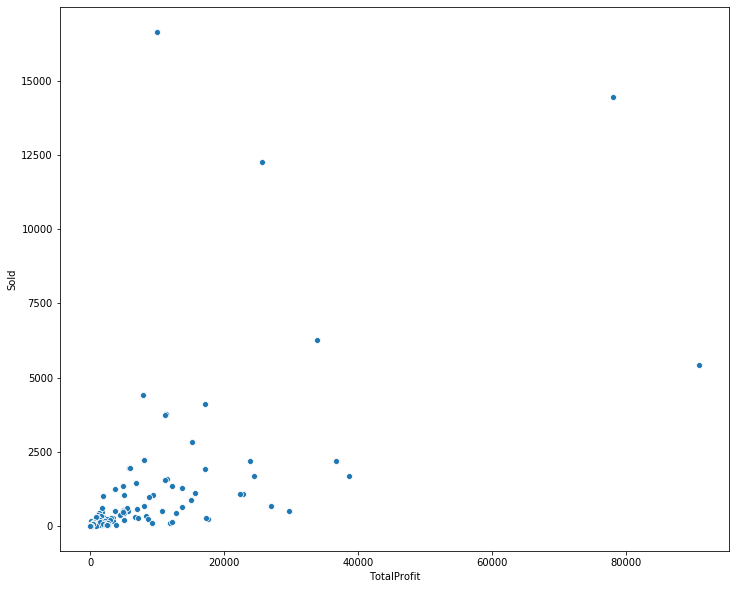

In [22]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x = 'TotalProfit', y = 'Sold', data = pp)

<span style="font-size:20px; color: red; font-weight: bold">Necessary calculations for determine the quadrant lines.</span>

In [23]:
# Calculation for y-axis quadrant from Smith and Kasavana matrix
pp.TotalProfit.sum() / pp.Sold.count()

5317.267379679144

In [24]:
# Calculation for x-axis quadrant from Smith and Kasavana matrix
(pp.Sold.values.sum() / pp.Sold.count()) * 0.7

484.2877005347593

<span style="font-size:20px; color: red; font-weight: bold">Algorithm to determine the quadrant of an item.</span>

In [25]:
sp = 484
tp = 5317
Group = []

for value1,value2 in zip(pp.Sold, pp.TotalProfit):
    if value1 >= sp and value2 >= tp:
        Group.append('Star')
    elif value1 >= sp:
        Group.append('Horses')
    elif value2 >= tp:
        Group.append('Puzzles')
    else:
        Group.append('Dogs')

<span style="font-size:20px; color: red; font-weight: bold">Adding new column called "Group" for categorizing products quadrants.</span>

In [26]:
pp['Group'] = Group

<span style="font-size:20px; color: red; font-weight: bold">Let's see our interactive dataframe...</span>

In [27]:
pp

,Products,Sold,TotalPrice,Price,TotalCost,Cost,TotalProfit,%ofSold,Profit,Group
Product,,,,,,,,,,
1.5 Kuşbaşı Kaşar,1.5 Kuşbaşı Kaşar,95,2850.0,30.0,1140.0,12.0,1710,0.073431,18.0,Dogs
Fındık,Fındık,476,2856.0,6.0,1142.4,2.4,1713,0.367926,3.6,Dogs
İçli Köfte,İçli Köfte,4097,28679.0,7.0,11471.6,2.8,17207,3.166788,4.2,Star
Adana Kebap,Adana Kebap,5415,151620.0,28.0,60648.0,11.2,90972,4.185540,16.8,Star
Kuzu Şiş,Kuzu Şiş,1697,64486.0,38.0,25794.4,15.2,38691,1.311701,22.8,Star
Büyük Su,Büyük Su,1366,8196.0,6.0,3278.4,2.4,4917,1.055854,3.6,Horses
Tulum Peyniri,Tulum Peyniri,16637,16637.0,1.0,6654.8,0.4,9982,12.859616,0.6,Star
Gavurdağ Salatası,Gavurdağ Salatası,1034,15510.0,15.0,6204.0,6.0,9306,0.799233,9.0,Star
Kola,Kola,3790,18950.0,5.0,7580.0,2.0,11370,2.929491,3.0,Star


<span style="font-size:20px; color: red; font-weight: bold">Explanation of groups and strategies that can be followed.
</span>

<span style="font-size:15px; color: black; font-weight: bold"> - Stars are highly popular and more profitable which means that they are contributing heavily to the margin and popularity of the restaurant than others. These dishes are your specialties in the market so you don’t have to worry about these but you must go for maintaining quality and quantity standards of the dishes.
</span>


<p style="font-size:15px; color: black; font-weight: bold"> - Puzzles are highly profitable but less popular. It means that these items are can contribute heavily to the profits if their popularity can be increased. So some popularity increasing techniques will do and this can be done by:</p>
<ul>
    <li>Place them at the most visible part of menu, to
capture the guest attention. This will increase their sale and as they
are already highly profitable which means in the end their
contribution to the restaurants profits will be high. 
    </li>
 <li>
     Another strategy can be giving add-ons. It will increase the
popularity.
    </li>
 <li>
 Price can be decreased to increase popularity. This can be very
good technique. But it is very important to note that by decreasing
prices we will be decreasing profits from them. So proper pricing
strategy should be coined.      
     </li>
</ul>
     
 

<p style="font-size:15px; color: black; font-weight: bold"> - Horses are highly popular but less profitable. It
means we have to increase the profit margins from these. For this management we can:</p>
<ul>
    <li>Go for appropriate profit increasing techniques like increase price.
People will not mind paying more as they love these items but it
should be noted that it doesn’t mean an unreasonable hike in prices.
A thorough study of the market will reveal the appropriate price
and pricing strategy for these.
    </li>
 <li>
     Reducing portion size can be another useful strategy to increase
margins as it will decrease food cost.
    </li>
 <li>
 Place them away from focal point in the menu. This will not affect
their sale as they are already very popular items of this menu, but
it will help in increasing sale of other items.
     </li>
</ul>

<p style="font-size:15px; color: black; font-weight: bold"> - Dogs are neither profitable nor popular. The best possible strategy for these items is to remove these from the menu and introduce some new items.</p>


In [28]:
# Number of each group 
pp.Group.value_counts()

Dogs       132
Star        37
Puzzles     10
Horses       8
Name: Group, dtype: int64

<span style="font-size:20px; color: red; font-weight: bold">Plotting profitability/popularity dataframe with quadrant and groups.</span>

In [29]:
# plt.figure(figsize=(12, 10))
# sns.scatterplot(x = 'TotalProfit', y = 'Sold', data = pp, hue = 'Group')
# plt.axvline(5317, color='black')
# plt.axhline(484, color='black')

<span style="font-size:20px; color: red; font-weight: bold">Plotting interactive profitability/popularity graph with quadrant and groups.</span>

In [30]:
from bokeh.io import show, output_file,curdoc 
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html, components
from bokeh.palettes import Spectral6 
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Span

In [31]:
group_list = pp.Group.unique().tolist()
source = ColumnDataSource(data ={
    'x'    : pp.TotalProfit,
    'y'    : pp.Sold,
    'products'  : pp.index.values,
    'group'    : pp.Group
})
color_mapper = CategoricalColorMapper(factors = group_list, palette = Spectral6)

p = figure(title = 'Profit / Popularity',plot_height = 700, plot_width = 700)
hover = HoverTool( tooltips = [('Product','@products')])
p.add_tools(hover)
p.xaxis.axis_label = 'Profit'
p.yaxis.axis_label = 'Popularity'
vline = Span(location=5317, dimension='height', line_color='black', line_width=1)
hline = Span(location=484, dimension='width', line_color='black', line_width=1)
p.circle(x = 'x', y= 'y', source=source, fill_alpha = 0.8, color=dict(field='group', transform = color_mapper), legend = 'group')
p.legend.location = 'top_right'
p.renderers.extend([vline, hline])
curdoc().add_root(p)
curdoc().title = 'Pop'
script, div = components(p)
show(p)

<span style="font-size:20px; color: red; font-weight: bold">Let's see our interactive graph with quadrant and groups...</span>






<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>Bokeh Plot</title>
      
      
        
          
        <link rel="stylesheet" href="https://cdn.pydata.org/bokeh/release/bokeh-1.2.0.min.css" type="text/css" />
        
        
          
        <script type="text/javascript" src="https://cdn.pydata.org/bokeh/release/bokeh-1.2.0.min.js"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="6c012fd1-b2af-4846-8335-f82974570bd4" data-root-id="1003"></div>
            
          
        
      
      
        <script type="application/json" id="1158">
          {"237b9cb2-c2c0-47b1-bfb7-5629ed443126":{"roots":{"references":[{"attributes":{"axis_label":"Popularity","formatter":{"id":"1047","type":"BasicTickFormatter"},"ticker":{"id":"1020","type":"BasicTicker"}},"id":"1019","type":"LinearAxis"},{"attributes":{"source":{"id":"1001","type":"ColumnDataSource"}},"id":"1045","type":"CDSView"},{"attributes":{},"id":"1020","type":"BasicTicker"},{"attributes":{},"id":"1047","type":"BasicTickFormatter"},{"attributes":{"dimension":1,"ticker":{"id":"1020","type":"BasicTicker"}},"id":"1023","type":"Grid"},{"attributes":{"bottom_units":"screen","fill_alpha":{"value":0.5},"fill_color":{"value":"lightgrey"},"left_units":"screen","level":"overlay","line_alpha":{"value":1.0},"line_color":{"value":"black"},"line_dash":[4,4],"line_width":{"value":2},"render_mode":"css","right_units":"screen","top_units":"screen"},"id":"1051","type":"BoxAnnotation"},{"attributes":{"items":[{"id":"1053","type":"LegendItem"}]},"id":"1052","type":"Legend"},{"attributes":{"factors":["Dogs","Star","Horses","Puzzles"],"palette":["#3288bd","#99d594","#e6f598","#fee08b","#fc8d59","#d53e4f"]},"id":"1002","type":"CategoricalColorMapper"},{"attributes":{"dimension":"height","location":5317},"id":"1039","type":"Span"},{"attributes":{"label":{"field":"group"},"renderers":[{"id":"1044","type":"GlyphRenderer"}]},"id":"1053","type":"LegendItem"},{"attributes":{"callback":null,"data":{"group":["Dogs","Dogs","Star","Star","Star","Horses","Star","Star","Star","Star","Star","Star","Star","Horses","Star","Star","Star","Puzzles","Horses","Star","Star","Star","Star","Star","Dogs","Horses","Star","Star","Star","Star","Star","Horses","Star","Star","Dogs","Puzzles","Star","Horses","Dogs","Star","Dogs","Star","Star","Star","Dogs","Dogs","Dogs","Dogs","Star","Dogs","Star","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Puzzles","Dogs","Star","Puzzles","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Star","Dogs","Dogs","Star","Horses","Dogs","Puzzles","Dogs","Dogs","Dogs","Dogs","Star","Dogs","Horses","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Puzzles","Dogs","Dogs","Dogs","Dogs","Dogs","Star","Puzzles","Dogs","Dogs","Dogs","Dogs","Puzzles","Puzzles","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Puzzles","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs","Dogs"],"products":["1.5 Ku\u015fba\u015f\u0131 Ka\u015far","F\u0131nd\u0131k","\u0130\u00e7li K\u00f6fte","Adana Kebap","Kuzu \u015ei\u015f","B\u00fcy\u00fck Su","Tulum Peyniri","Gavurda\u011f Salatas\u0131","Kola","Ayran","K\u00fcnefe","\u00c7\u00f6p \u015ei\u015f","F\u0131nd\u0131k Lahmacun","\u015ealgam Suyu","Ac\u0131l\u0131 \u015ealgam","Lahmacun","Az \u00c7orba","1.5 Adana Kebap","\u00c7oban Salata","K\u00fc\u00e7\u00fck Su","Ezogelin","Ac\u0131l\u0131 Lahmacun","Adana D\u00fcr\u00fcm","Ku\u015fba\u015f\u0131 Ka\u015farl\u0131","1.5 Kanat","Ka\u015farl\u0131 Pide","Urfa Kebap","F\u0131st\u0131kl\u0131 Baklava","Rak\u0131 35cl","Kuver","Sar\u0131msak K\u00f6z","Meze","Patl\u0131can Salata","Yar\u0131m Adana","Ci\u011fer Yar\u0131m","Pirzola","Tavuk Kanat","Soda","-KjriU9GcbAgEdffQIo2","\u00c7i\u011f K\u00f6fte","K\u00f6po\u011flu","Ku\u015fba\u015f\u0131l\u0131 Pide","Tavuk \u015ei\u015f","Urfa D\u00fcr\u00fcm","Atom","\u00c7\u00f6p \u015ei\u015f Yar\u0131m","Sucuk Ka\u015far Pide","Cips","Sarma Beyti","Fanta","Rak\u0131 20cl","Yo\u011furtlu Kebap","1.5 Ka\u015farl\u0131 Pide","Yar\u0131m Urfa","1.5 Sarma Beyti","Fusetea Limon","500 gr F\u0131st\u0131k","Rak\u0131 50cl","Ka\u015f\u0131k Salata","Ci\u011fer \u015ei\u015f","Kar\u0131\u015f\u0131k Izgara 1 Ki\u015fi","Peynir Taba\u011f\u0131","Tek Rak\u0131","Haydari","\u015eak\u015fuka","Dondurmal\u0131 Baklava","Peymacun","Ci\u011fer D\u00fcr\u00fcm","Beyaz \u015earap 70cl","K\u0131ymal\u0131 Pide","Kar\u0131\u015f\u0131k Pide","\u00c7ay","Tuborg Bira","Cola Zero","1.5 K\u0131ymal\u0131","Iskender Doner","1.5 K\u0131ymal\u0131 Ka\u015farl\u0131","Domatesli Kebap","Ka\u015far Yumurta","Cac\u0131k","Rak\u0131 Duble","\u00c7i\u011fk\u00f6fte Yar\u0131m","Tavuk D\u00fcr\u00fcm","1.5 Patl\u0131can Kebap","1.5 \u00c7\u00f6p \u015ei\u015f","Kuzu D\u00fcr\u00fcm","S\u00fczme Yo\u011furt","Yar\u0131m Baklava","K\u0131ymal\u0131 Ka\u015farl\u0131","Kar\u0131\u015f\u0131k 2 Ki\u015fi","1.5 Pirzola","Sprite","Dondurmal\u0131 K\u00fcnefe","Ezme","Lava\u015f","Patl\u0131can Kebap","Kaburga","Yarim Kaburga","Dondurma","Ye\u015fil Salata","Vi\u015fne Meyve Suyu","Kar\u0131\u015f\u0131k 4 Ki\u015fi","Kar\u0131\u015f\u0131k 3 Ki\u015fi","Kar\u0131\u015f\u0131k Salata","Pirzola Yar\u0131m","Yar\u0131m Baklava Dondurmal\u0131","Kuzu Yar\u0131m","Fusetea \u015eeftali","Yar\u0131m Dondurma","Tek \u00c7\u00f6p \u015ei\u015f","Kanat Yar\u0131m","Tek \u015ei\u015f Ci\u011fer","Alinazik Kuzu","Kadeh Beyaz","Tavuklu Pide","Kuyruk Tek \u015ei\u015f","K\u0131rm\u0131z\u0131 \u015earap 70cl","1.5 Tavuk \u015ei\u015f","Rak\u0131 100cl","Tek Par\u00e7a Kaburga","Kar\u0131\u015f\u0131k Meyve","Alt\u0131 Ezmeli","Vali Kebap","Sebzeli Kebap","Rak\u0131 70cl","1.5 Baklava","Kadeh K\u0131rm\u0131z\u0131","-KkuZvraaXV9PXqCxZ7n","Kavun","\u015eeftali Meyve Suyu","1.5 D\u00fcr\u00fcm","Tavuk Yar\u0131m","1.5 Ku\u015fba\u015f\u0131l\u0131","Tek Par\u00e7a Pirzola","1 KG Baklava","K\u0131yma Yumurta","Winston Sigara","1.5 Urfa Kebap","1.5 Ci\u011fer","1.5 Kuzu \u015ei\u015f","Ord\u00f6vr Taba\u011f\u0131","Tek Baklava","1.5 Sucuk Ka\u015far","T\u0131rnakl\u0131","Marlboro Sigara","Kent Sigara","Parliament Sigara","Duble Gavurda\u011f\u0131 Salatas\u0131","Duble \u00c7oban","Yar\u0131m Ka\u015far Pide","1.5 Ka\u015far Yumurta","1.5 Kar\u0131\u015f\u0131k Pide","F\u0131st\u0131kl\u0131 Kebap","D\u00fcr\u00fcm \u00c7i\u011fk\u00f6fte","Pasta","500 GR Baklava","Kar\u0131\u015f\u0131k Meyve Suyu","Samsun Sigara","Yar\u0131m B\u00f6rek","1.5 K\u0131ymal\u0131 Yumurtal\u0131","1 KG Tulum Dbak\u0131r","B\u00f6brek","1.5 Kar\u0131\u015f\u0131k Izgara","Kaday\u0131f F\u0131st\u0131kl\u0131 Dondurmal\u0131","B\u0131ld\u0131rc\u0131n","Yar\u0131m B\u0131ld\u0131rc\u0131n","T\u00fcrk Kahvesi","F\u0131st\u0131k Porsiyon","1.5 Kuzu D\u00fcr\u00fcm","Tekirda\u011f 35cl","Sigara B\u00f6re\u011fi","Tekirda\u011f 50cl","Tekirda\u011f 70cl","Kaday\u0131f Cevizli","Kaday\u0131f F\u0131st\u0131kl\u0131","Kaday\u0131f Cevizli Dondurmal\u0131","1.5 Yo\u011furtlu","Efe Gold 70cl","Taze Portakal Suyu","Kefir","1 KG Kaday\u0131f F\u0131st\u0131kl\u0131","1 KG F\u0131st\u0131k","Ye\u015fil Efe 100cl","Ku\u015fba\u015f\u0131 Ka\u015far Yar\u0131m","Karpuz","Bulgur","Kulah Dondurma"],"x":{"__ndarray__":"rgYAALEGAAA3QwAAXGMBACOXAAA1EwAA/iYAAFokAABqLAAAdmQAADhDAABqWQAAvxYAAB0HAAAHFwAADjEBAIAfAABwIAAAgw4AAAkfAACsOwAAZ4QAABtdAACYHwAAQAgAAPwSAABTjwAA9C8AAMhzAADXKwAA6BoAALQTAACpLAAAVBsAAIANAABJMgAAiToAADEHAADnAAAAESIAAEwDAADEFQAArl8AAH41AAAjAgAApAsAAPwHAACABwAApjUAAP4EAABFaQAASg0AAGQBAADoBQAA0AIAAL8BAAB4AAAA6EQAAOwCAABdVwAAwCEAAE0EAADwCwAAkAYAALQBAADnEwAAmgIAADwJAACIAgAAaRUAAOwEAAAtAAAA5ysAAJ0OAAAVBgAAQBoAAIsDAAAFBAAAvAIAAAECAADqPAAAWAIAAPkSAACkAQAAMwcAAJQRAABzAwAAzgMAAD4TAACAQwAAkAkAALEDAAD5CQAAQwMAAJUAAADrKQAAohsAAIUGAADZBQAA/gMAAGYAAABQLgAANiQAALUCAAA+BwAAhgIAAKQLAAB+AwAA/wEAAHEAAADmAQAA4gAAAIATAAAEBQAAtAAAAMQAAADIBAAAKwUAAEIPAABDAAAAVAAAAB4DAAAOBwAALwQAAJcvAAApAwAAVAYAAHgAAAC+AQAAhwAAAJwIAAAmBAAAWgMAAOsCAAAQBQAAcAUAAHYAAABwCAAAIAoAAPgHAABsAAAAxAAAAJAAAAAmAAAAlAAAAE8AAACiAAAADQIAANgAAACoAAAAgQAAAOoAAACTAAAAGwAAAGwAAACYBwAAmQAAAAUAAAAkAAAA5gAAAMsBAABaAAAAMgEAAHgAAACTAAAASAAAABMAAAASAAAA0gAAABUJAAAGAAAAMgoAAPkJAAAcAgAAfgAAAOoBAAB2AgAAcgMAAGkBAAADAAAAKgAAADAAAACiAAAACQAAAGAAAABgAAAADwAAAA==","dtype":"int32","shape":[187]},"y":{"__ndarray__":"XwAAANwBAAABEAAAJxUAAKEGAABWBQAA/UAAAAoEAADODgAA1y8AAHgHAABCBAAAlQcAAF8CAACtBwAAfjgAAMAIAABaAQAABAIAAD4RAAANCwAAhRgAAJ8IAACiAgAAWAAAABwCAACICAAAVAUAAAgCAACdDgAAmwUAABsEAAA0BgAARwIAACABAAC/AQAAfAMAAP8DAAALAAAAyQMAALAAAAAEAgAApQYAAPQEAAByAAAA2AAAANUAAABAAQAAjgIAAKoBAACzAgAAogAAABsAAAB+AAAAGAAAAJUAAAAFAAAA9QAAAGgAAAApBAAA8AAAAG8BAAAbAQAAXgEAAFsAAAC/AQAAbwAAAMUAAAASAAAAYQIAAGkAAAAmAAAAGQYAAN8EAAB2AAAAQAEAAD8AAAAxAAAASQAAAGsAAABqBAAAfQAAAPoBAAAOAAAAQAAAAHcBAAC4AAAAywAAAOMBAAAgAQAAPAAAADsBAADgAAAArgAAAKYAAAD/AQAABgEAAHkAAADQAAAAjgAAACIAAABoAAAAZwAAAE0AAABnAAAATQAAANgAAAAqAQAAjgAAABUAAAA2AAAAKgAAANAAAABrAAAAFAAAACkAAAAiAAAAPwAAAB8AAAAQAAAADgAAACYAAAArAAAAMwAAAIMAAABHAAAAhwAAAAUAAABdAAAALQAAAKcAAAB2AAAANwAAAFMAAAAbAAAAkQAAABIAAABaAAAAWgAAAEQAAAAMAAAAUgAAAAoAAAArAAAAEwAAAAsAAAAUAAAAIwAAABIAAAAcAAAACQAAAA0AAAAHAAAACQAAAAQAAABRAAAAMwAAAAEAAAAEAAAAEAAAABEAAAAFAAAABgAAAAoAAAAHAAAABgAAAAgAAAACAAAADgAAAB8AAAABAAAAHgAAABcAAAA8AAAADgAAACsAAAAVAAAABwAAAEMAAAABAAAAAQAAAAEAAAABAAAAAQAAABAAAAAQAAAABQAAAA==","dtype":"int32","shape":[187]}},"selected":{"id":"1061","type":"Selection"},"selection_policy":{"id":"1060","type":"UnionRenderers"}},"id":"1001","type":"ColumnDataSource"},{"attributes":{"location":484},"id":"1040","type":"Span"},{"attributes":{},"id":"1024","type":"PanTool"},{"attributes":{"below":[{"id":"1014","type":"LinearAxis"}],"center":[{"id":"1018","type":"Grid"},{"id":"1023","type":"Grid"},{"id":"1052","type":"Legend"}],"left":[{"id":"1019","type":"LinearAxis"}],"plot_height":700,"plot_width":700,"renderers":[{"id":"1044","type":"GlyphRenderer"},{"id":"1039","type":"Span"},{"id":"1040","type":"Span"}],"title":{"id":"1004","type":"Title"},"toolbar":{"id":"1030","type":"Toolbar"},"x_range":{"id":"1006","type":"DataRange1d"},"x_scale":{"id":"1010","type":"LinearScale"},"y_range":{"id":"1008","type":"DataRange1d"},"y_scale":{"id":"1012","type":"LinearScale"}},"id":"1003","subtype":"Figure","type":"Plot"},{"attributes":{},"id":"1025","type":"WheelZoomTool"},{"attributes":{"overlay":{"id":"1051","type":"BoxAnnotation"}},"id":"1026","type":"BoxZoomTool"},{"attributes":{},"id":"1060","type":"UnionRenderers"},{"attributes":{},"id":"1027","type":"SaveTool"},{"attributes":{"callback":null,"tooltips":[["Product","@products"]]},"id":"1037","type":"HoverTool"},{"attributes":{},"id":"1061","type":"Selection"},{"attributes":{},"id":"1028","type":"ResetTool"},{"attributes":{"text":"Profit / Popularity"},"id":"1004","type":"Title"},{"attributes":{},"id":"1029","type":"HelpTool"},{"attributes":{"callback":null},"id":"1006","type":"DataRange1d"},{"attributes":{"active_drag":"auto","active_inspect":"auto","active_multi":null,"active_scroll":"auto","active_tap":"auto","tools":[{"id":"1024","type":"PanTool"},{"id":"1025","type":"WheelZoomTool"},{"id":"1026","type":"BoxZoomTool"},{"id":"1027","type":"SaveTool"},{"id":"1028","type":"ResetTool"},{"id":"1029","type":"HelpTool"},{"id":"1037","type":"HoverTool"}]},"id":"1030","type":"Toolbar"},{"attributes":{"callback":null},"id":"1008","type":"DataRange1d"},{"attributes":{},"id":"1010","type":"LinearScale"},{"attributes":{},"id":"1049","type":"BasicTickFormatter"},{"attributes":{},"id":"1012","type":"LinearScale"},{"attributes":{"fill_alpha":{"value":0.8},"fill_color":{"field":"group","transform":{"id":"1002","type":"CategoricalColorMapper"}},"line_color":{"field":"group","transform":{"id":"1002","type":"CategoricalColorMapper"}},"x":{"field":"x"},"y":{"field":"y"}},"id":"1042","type":"Circle"},{"attributes":{"axis_label":"Profit","formatter":{"id":"1049","type":"BasicTickFormatter"},"ticker":{"id":"1015","type":"BasicTicker"}},"id":"1014","type":"LinearAxis"},{"attributes":{"fill_alpha":{"value":0.1},"fill_color":{"value":"#1f77b4"},"line_alpha":{"value":0.1},"line_color":{"value":"#1f77b4"},"x":{"field":"x"},"y":{"field":"y"}},"id":"1043","type":"Circle"},{"attributes":{},"id":"1015","type":"BasicTicker"},{"attributes":{"data_source":{"id":"1001","type":"ColumnDataSource"},"glyph":{"id":"1042","type":"Circle"},"hover_glyph":null,"muted_glyph":null,"nonselection_glyph":{"id":"1043","type":"Circle"},"selection_glyph":null,"view":{"id":"1045","type":"CDSView"}},"id":"1044","type":"GlyphRenderer"},{"attributes":{"ticker":{"id":"1015","type":"BasicTicker"}},"id":"1018","type":"Grid"}],"root_ids":["1003"]},"title":"Pop","version":"1.2.0"}}
        </script>
        <script type="text/javascript">
          (function() {
            var fn = function() {
              Bokeh.safely(function() {
                (function(root) {
                  function embed_document(root) {
                    
                  var docs_json = document.getElementById('1158').textContent;
                  var render_items = [{"docid":"237b9cb2-c2c0-47b1-bfb7-5629ed443126","roots":{"1003":"6c012fd1-b2af-4846-8335-f82974570bd4"}}];
                  root.Bokeh.embed.embed_items(docs_json, render_items);
                
                  }
                  if (root.Bokeh !== undefined) {
                    embed_document(root);
                  } else {
                    var attempts = 0;
                    var timer = setInterval(function(root) {
                      if (root.Bokeh !== undefined) {
                        embed_document(root);
                        clearInterval(timer);
                      }
                      attempts++;
                      if (attempts > 100) {
                        console.log("Bokeh: ERROR: Unable to run BokehJS code because BokehJS library is missing");
                        clearInterval(timer);
                      }
                    }, 10, root)
                  }
                })(window);
              });
            };
            if (document.readyState != "loading") fn();
            else document.addEventListener("DOMContentLoaded", fn);
          })();
        </script>
    
  </body>
  
</html>